In [86]:
import json
import os
import string

import pandas as pd
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import gensim

import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
civil_code = pd.read_csv('tmp/civil_code.csv')
court_orders = pd.read_csv('tmp/civil_code_court_orders.csv.gz', compression='gzip')

In [11]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=civil_code['lemmas'].str.split()))
civil_code['phrased'] = civil_code['lemmas'].str.split().map(lambda x: ' '.join(phraser[x]))

In [12]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=court_orders['lemmas'].str.split()))
court_orders['phrased'] = court_orders['lemmas'].str.split().map(lambda x: ' '.join(phraser[x]))

In [13]:
civil_code['source'] = 'civil_code'
court_orders['source'] = 'court_orders'

In [18]:
df = pd.concat([
    civil_code.reset_index()[['index', 'phrased', 'source']], 
    court_orders.reset_index()[['index', 'phrased', 'source']]
]).reset_index(drop=True)

In [20]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(words=row['phrased'].split(), tags=[row.name])
documents = df.apply(td, axis=1).tolist()

In [21]:
%%time
model = gensim.models.doc2vec.Doc2Vec()
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 17min 25s, sys: 24.1 s, total: 17min 49s
Wall time: 6min 44s


In [92]:
if not os.path.exists('tmp/doc2vec/'):
    os.mkdir('tmp/doc2vec')
model.save('tmp/doc2vec/civil_code.model')

In [22]:
df['vectors'] = model.docvecs.vectors_docs.tolist()

In [25]:
df['pca'] = PCA(n_components=2).fit_transform(df['vectors'].tolist()).tolist()

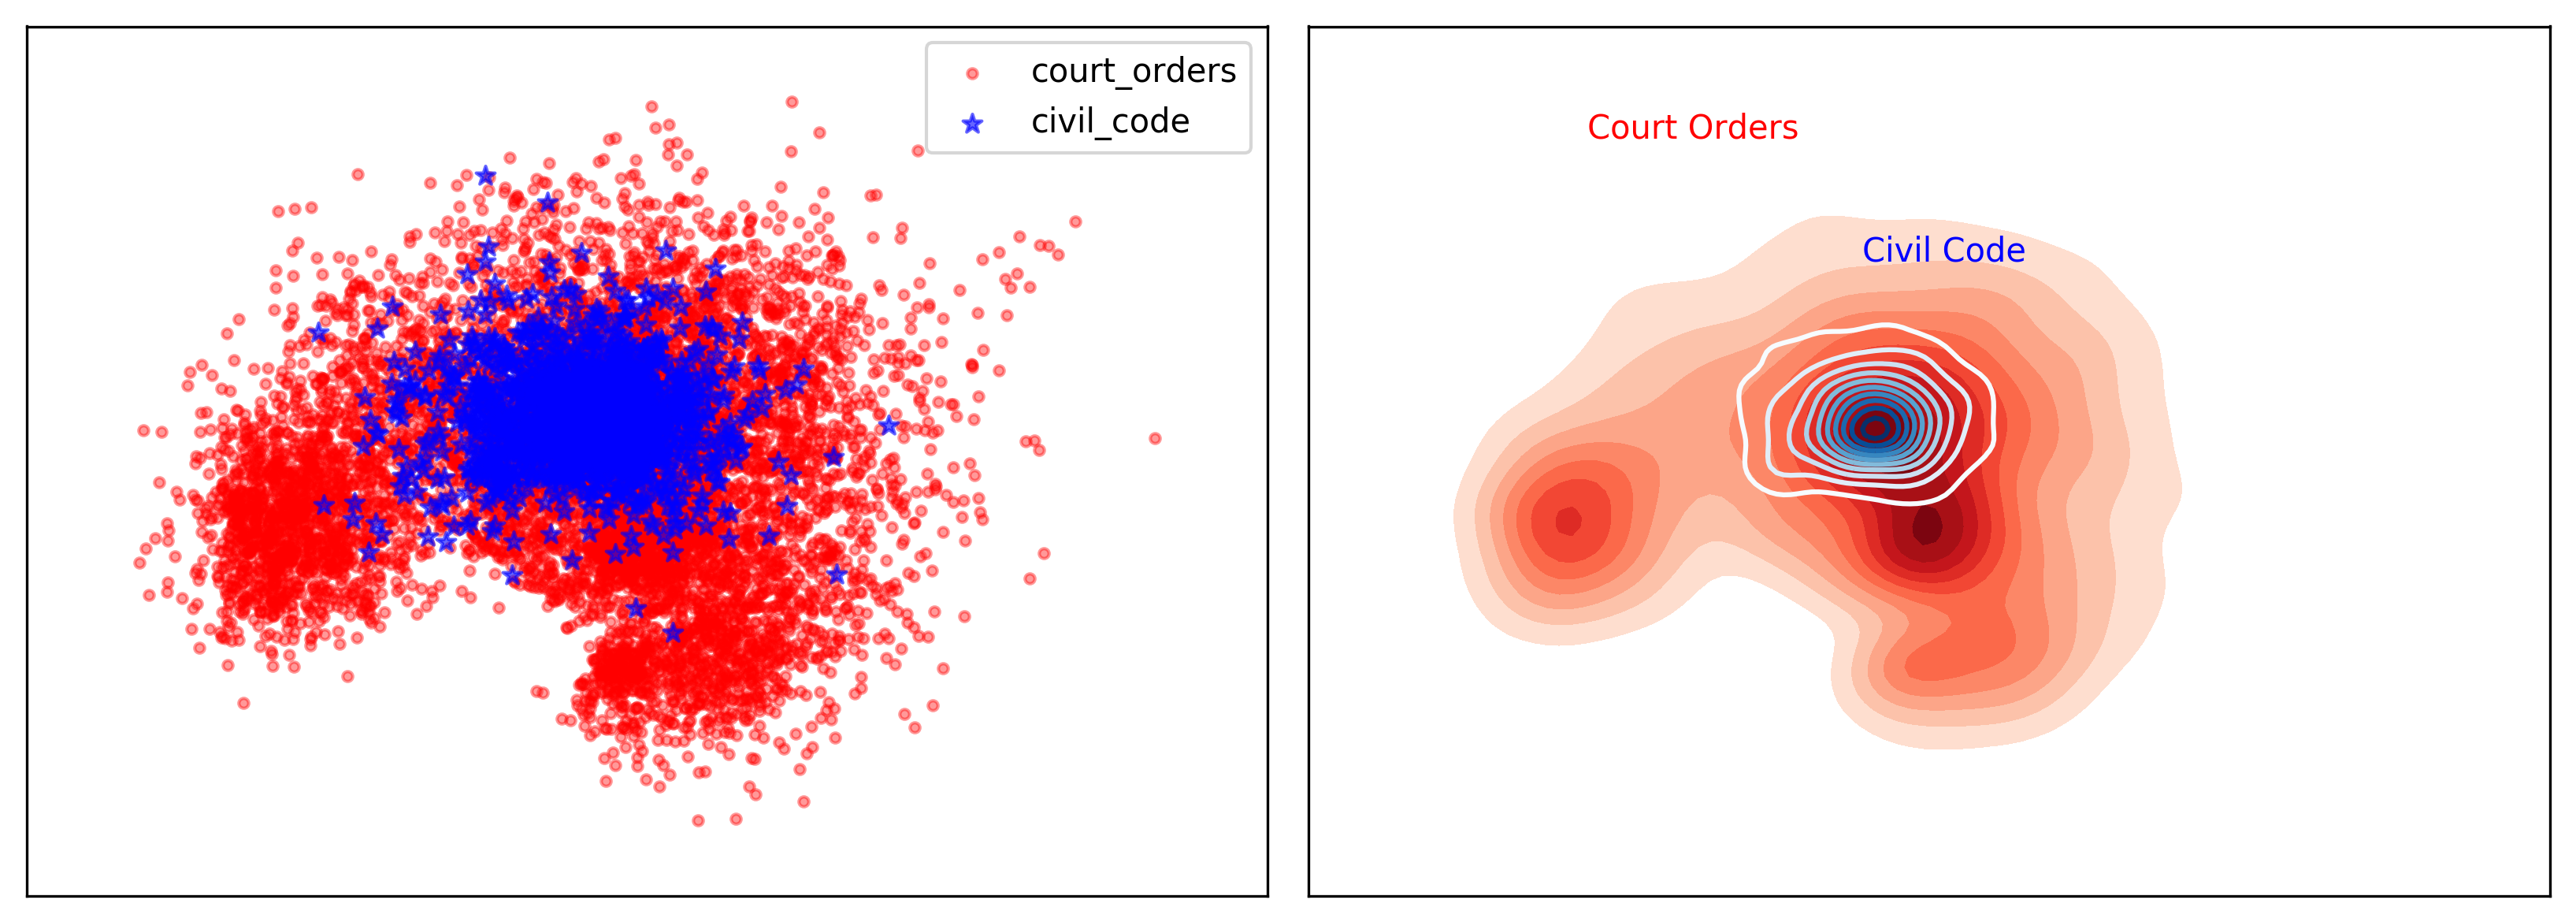

In [26]:
pca_j = np.array(df[df['source'] == 'court_orders']['pca'].tolist())
pca_cc = np.array(df[df['source'] == 'civil_code']['pca'].tolist())

disable_ticks = lambda x: x.tick_params(axis='both', which='both', left=False, bottom=False,
                                        labelleft=False, labelbottom=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex='all', sharey='all')
ax1.scatter(pca_j[:, 0], pca_j[:, 1], c='r', marker='.', label='court_orders', alpha=.4)
ax1.scatter(pca_cc[:, 0], pca_cc[:, 1], c='b', marker='*', label='civil_code', alpha=.6)
disable_ticks(ax1)
ax1.legend()

ax2 = sns.kdeplot(pca_j[:, 0], pca_j[:, 1], ax=ax2, legend=False, cmap='Reds', shade=True, shade_lowest=False)
ax2.text(-5, 8, "Court Orders", size=10, color='red')
ax2 = sns.kdeplot(pca_cc[:, 0], pca_cc[:, 1], ax=ax2, legend=False, cmap='Blues', shade_lowest=False)
ax2.text(0, 5, "Civil Code", size=10, color='blue')
disable_ticks(ax2)

plt.tight_layout()
plt.autoscale()
plt.show()

In [91]:
if not os.path.exists('tmp/vectors/'):
    os.mkdir('tmp/vectors')

pd.merge(
    df[df['source'] == 'civil_code'][['index', 'vectors']],
    civil_code.reset_index(),
    on='index', how='inner'
).drop(columns=['index', 'source']).to_csv('tmp/vectors/civil_code.csv.gz', 
                                           compression='gzip', index=False)
pd.merge(
    df[df['source'] == 'court_orders'][['index', 'vectors', 'pca']],
    court_orders.reset_index(),
    on='index', how='inner'
).drop(columns=['index','source']).to_csv('tmp/vectors/civil_court_orders.csv.gz', 
                                          compression='gzip', index=False)

In [45]:
# df = pd.read_csv('tmp/civil_court_orders_to_classifier.csv.gz', compression='gzip')
# df.loc[:, ['vectors', 'pca', 'money', 'descr_articles']] = df.loc[:, ['vectors', 'pca', 'money', 'descr_articles']].applymap(eval)